**EXP1 Predicitng Missing Cell-Types from Bulks using Non-Negative Least Squares regression Residual**

*This file includes EXP1 specifics (outlined below), as well as the data preprocessing, QC, and creates the pseudobulks used in other experiments.*

Data downloaded from: https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE176171
Original paper: https://pubmed.ncbi.nlm.nih.gov/35296864/ PMID: 35296864
Source name	omental adipose tissue
Organism	Homo sapiens
Characteristics	tissue: white adipose tissue
Sex: female
age: 29y
bmi: 49.3
surgery: VSG

Experimental Details: https://docs.google.com/spreadsheets/d/1fMV_URm95iPh-6rew-Be27I1-i8PNgGNWi2D_UO2V9w/edit#gid=0
Summary: Preprocessing single-nucleus data from adipose tissue extracted during surgery. Creating 1000 realistic-proportions pseudobulks in 10 separate files with each file containing 1000 bulks. Then, removing 1, 4, and 12 celltypes from each patient-file. Celltypes removed are chosen at random.

*This file can be run one kernel at a time, or all at once*

In [70]:
# import the dependencies
import sys
sys.path.insert(1, '../../')
sys.path.insert(1, '../')
sys.path.insert(1, '../../../../../')

from Greene_rotation_project.sc_bulk_ood_AI.sn_sc_preprocessing import sn_sc_preprocess
from Greene_rotation_project.sc_bulk_ood_AI.method_comparison import validation_plotting as vp
from importlib import reload
reload(sn_sc_preprocess)
# general imports
import warnings
import numpy as np
from numpy import random
import pandas as pd
import scanpy as sc
from anndata import AnnData as ad
from tabulate import tabulate

import tensorflow as tf
from tensorflow.keras.utils import to_categorical

import scipy as sp
from scipy.stats import spearmanr, pearsonr
from scipy.sparse import coo_matrix
from scipy.sparse import csr_matrix
import scipy.stats as stats
from collections import Counter
import scipy as sp
from scipy.optimize import nnls

# Images, plots, display, and visualization
import matplotlib.pyplot as plt
import seaborn as sns
import umap
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

# programming stuff
import time
import os, sys
import pickle
from pathlib import Path


In [71]:
#Fcn to make table of cell proportions
def make_prop_table(adata, obs):
    num_cell_counter = Counter(adata.obs[obs])
    num_cells = list()
    cell_types = list()
    prop_cells = list()
    tot_count = 0
    tot_prop = 0

    for cell in num_cell_counter:
        num_cells.append(num_cell_counter[cell])
        cell_types.append(cell)
        tot_count = tot_count + num_cell_counter[cell]

    for cell in num_cell_counter:
        proportion = num_cell_counter[cell] / tot_count
        prop_cells.append(proportion)
        tot_prop = tot_prop + proportion

    cell_types.append('Total')
    num_cells.append(tot_count)
    prop_cells.append(tot_prop)
    table = {'Cell_Types': cell_types, 
        'Num_Cells': num_cells, 
        'Prop_Cells': prop_cells}
    table = pd.DataFrame(table)
    return table    

In [3]:
#####################
### set the study ###
#####################
#results paths:
res_name = "MCT_snadp_EXP1"
actual_path = os.getcwd()
path = f"{actual_path}/../../rnaseq_translator/data/adipose/GSE176171"
aug_data_path = f"{actual_path}/../data/EXP1/"

#if you want pseudobulks to be made:
make_pseudos = True
#if you want pseudos to have all cells:
all_cells = True

**Reading in all the data:**

In [72]:
cell_meta_name = f"{path}/GSE176171_cell_metadata.tsv.gz"
cell_meta = pd.read_csv(cell_meta_name, sep='\t')
cell_meta

/beevol/home/ivicha/miniconda3/envs/env_ml/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (19,20,21,22,23,24,30,32,33,36,37,39,40,41) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,cell_id,biosample_id,biosample_type,library_preparation_protocol__ontology_id,library_preparation_protocol__ontology_label,donor_id,species__ontology_id,species__ontology_label,organ__ontology_id,organ__ontology_label,...,ribosomal_protein_percent,sct__n_umis,sct__n_genes,cell_cycle__s_score,cell_cycle__g2m_score,cell_cycle__phase,cell_type__ontology_id,cell_type__ontology_label,cell_type__custom,cell_subtype__custom
0,Hs_OAT_01-1_AAACCCAAGCAAGGAA,Hs_OAT_01-1,PrimaryBioSample_Tissue,EFO:0009922,10x 3' v3 sequencing,TP01,NCBITaxon:9606,Homo sapiens,UBERON:0001013,adipose tissue,...,0.320758,5042,3178,0.013315,-0.002799,S,CL:0000077,mesothelial cell,mesothelium,hMes1
1,Hs_OAT_01-1_AAACCCAAGGGTGGGA,Hs_OAT_01-1,PrimaryBioSample_Tissue,EFO:0009922,10x 3' v3 sequencing,TP01,NCBITaxon:9606,Homo sapiens,UBERON:0001013,adipose tissue,...,0.489574,4905,2578,-0.051260,-0.012629,G1,CL:0000235,macrophage,macrophage,hMac3
2,Hs_OAT_01-1_AAACCCAAGTCTGGAG,Hs_OAT_01-1,PrimaryBioSample_Tissue,EFO:0009922,10x 3' v3 sequencing,TP01,NCBITaxon:9606,Homo sapiens,UBERON:0001013,adipose tissue,...,0.599401,3607,1808,0.046359,-0.009526,S,CL:0000235,macrophage,macrophage,hMac1
3,Hs_OAT_01-1_AAACCCACAGCCCAGT,Hs_OAT_01-1,PrimaryBioSample_Tissue,EFO:0009922,10x 3' v3 sequencing,TP01,NCBITaxon:9606,Homo sapiens,UBERON:0001013,adipose tissue,...,0.420800,5029,3041,0.018981,0.021519,G2M,CL:0000077,mesothelial cell,mesothelium,hMes3
4,Hs_OAT_01-1_AAACCCACATCTTCGC,Hs_OAT_01-1,PrimaryBioSample_Tissue,EFO:0009922,10x 3' v3 sequencing,TP01,NCBITaxon:9606,Homo sapiens,UBERON:0001013,adipose tissue,...,0.166098,4776,2539,0.028879,-0.005132,S,CL:0000136,fat cell,adipocyte,hAd2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
363865,Mm_POV_04-1_TTTGTTGCACTAGGTT,Mm_POV_04-1,PrimaryBioSample_Tissue,EFO:0009922,10x 3' v3 sequencing,NCD02.F,NCBITaxon:10090,Mus musculus,UBERON:0001013,adipose tissue,...,0.000000,1332,404,-0.006680,0.010435,G2M,CL:0002334,preadipocyte,ASPC,mASPC2
363866,Mm_POV_04-1_TTTGTTGGTATCATGC,Mm_POV_04-1,PrimaryBioSample_Tissue,EFO:0009922,10x 3' v3 sequencing,NCD02.F,NCBITaxon:10090,Mus musculus,UBERON:0001013,adipose tissue,...,0.086059,1466,776,-0.010295,-0.023509,G1,CL:0000136,fat cell,adipocyte,mAd1
363867,Mm_POV_04-1_TTTGTTGGTCCTGGTG,Mm_POV_04-1,PrimaryBioSample_Tissue,EFO:0009922,10x 3' v3 sequencing,NCD02.F,NCBITaxon:10090,Mus musculus,UBERON:0001013,adipose tissue,...,0.070028,1528,991,-0.017319,-0.007133,G1,CL:0000077,mesothelial cell,mesothelium,mMes1
363868,Mm_POV_04-1_TTTGTTGGTGTATTGC,Mm_POV_04-1,PrimaryBioSample_Tissue,EFO:0009922,10x 3' v3 sequencing,NCD02.F,NCBITaxon:10090,Mus musculus,UBERON:0001013,adipose tissue,...,0.138504,1478,511,-0.005107,0.027213,G2M,CL:0000077,mesothelial cell,mesothelium,mMes2


In [73]:
adata = sc.read_10x_mtx(path, prefix = 'GSE176171_Hs10X.counts.', var_names='gene_symbols', make_unique=True)

Only considering the two last: ['.mtx', '.gz'].
Only considering the two last: ['.mtx', '.gz'].


In [74]:
#extracting cell ids 
cell_ids = cell_meta[cell_meta["biosample_id"] == "Hs_OAT_01-1"]["cell_type__ontology_label"].values	
cell_ids

array(['mesothelial cell', 'macrophage', 'macrophage', ..., 'macrophage',
       'macrophage', 'smooth muscle cell'], dtype=object)

In [75]:
#getting common genes between sn and sc:
common_cells = np.intersect1d([adata.obs.index], [cell_meta["cell_id"].values])
common_cells= list(common_cells)
len(common_cells)

137684

In [76]:
cell_meta.index = cell_meta["cell_id"]
cell_meta

,cell_id,biosample_id,biosample_type,library_preparation_protocol__ontology_id,library_preparation_protocol__ontology_label,donor_id,species__ontology_id,species__ontology_label,organ__ontology_id,organ__ontology_label,...,ribosomal_protein_percent,sct__n_umis,sct__n_genes,cell_cycle__s_score,cell_cycle__g2m_score,cell_cycle__phase,cell_type__ontology_id,cell_type__ontology_label,cell_type__custom,cell_subtype__custom
cell_id,,,,,,,,,,,,,,,,,,,,,
Hs_OAT_01-1_AAACCCAAGCAAGGAA,Hs_OAT_01-1_AAACCCAAGCAAGGAA,Hs_OAT_01-1,PrimaryBioSample_Tissue,EFO:0009922,10x 3' v3 sequencing,TP01,NCBITaxon:9606,Homo sapiens,UBERON:0001013,adipose tissue,...,0.320758,5042,3178,0.013315,-0.002799,S,CL:0000077,mesothelial cell,mesothelium,hMes1
Hs_OAT_01-1_AAACCCAAGGGTGGGA,Hs_OAT_01-1_AAACCCAAGGGTGGGA,Hs_OAT_01-1,PrimaryBioSample_Tissue,EFO:0009922,10x 3' v3 sequencing,TP01,NCBITaxon:9606,Homo sapiens,UBERON:0001013,adipose tissue,...,0.489574,4905,2578,-0.051260,-0.012629,G1,CL:0000235,macrophage,macrophage,hMac3
Hs_OAT_01-1_AAACCCAAGTCTGGAG,Hs_OAT_01-1_AAACCCAAGTCTGGAG,Hs_OAT_01-1,PrimaryBioSample_Tissue,EFO:0009922,10x 3' v3 sequencing,TP01,NCBITaxon:9606,Homo sapiens,UBERON:0001013,adipose tissue,...,0.599401,3607,1808,0.046359,-0.009526,S,CL:0000235,macrophage,macrophage,hMac1
Hs_OAT_01-1_AAACCCACAGCCCAGT,Hs_OAT_01-1_AAACCCACAGCCCAGT,Hs_OAT_01-1,PrimaryBioSample_Tissue,EFO:0009922,10x 3' v3 sequencing,TP01,NCBITaxon:9606,Homo sapiens,UBERON:0001013,adipose tissue,...,0.420800,5029,3041,0.018981,0.021519,G2M,CL:0000077,mesothelial cell,mesothelium,hMes3
Hs_OAT_01-1_AAACCCACATCTTCGC,Hs_OAT_01-1_AAACCCACATCTTCGC,Hs_OAT_01-1,PrimaryBioSample_Tissue,EFO:0009922,10x 3' v3 sequencing,TP01,NCBITaxon:9606,Homo sapiens,UBERON:0001013,adipose tissue,...,0.166098,4776,2539,0.028879,-0.005132,S,CL:0000136,fat cell,adipocyte,hAd2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Mm_POV_04-1_TTTGTTGCACTAGGTT,Mm_POV_04-1_TTTGTTGCACTAGGTT,Mm_POV_04-1,PrimaryBioSample_Tissue,EFO:0009922,10x 3' v3 sequencing,NCD02.F,NCBITaxon:10090,Mus musculus,UBERON:0001013,adipose tissue,...,0.000000,1332,404,-0.006680,0.010435,G2M,CL:0002334,preadipocyte,ASPC,mASPC2
Mm_POV_04-1_TTTGTTGGTATCATGC,Mm_POV_04-1_TTTGTTGGTATCATGC,Mm_POV_04-1,PrimaryBioSample_Tissue,EFO:0009922,10x 3' v3 sequencing,NCD02.F,NCBITaxon:10090,Mus musculus,UBERON:0001013,adipose tissue,...,0.086059,1466,776,-0.010295,-0.023509,G1,CL:0000136,fat cell,adipocyte,mAd1
Mm_POV_04-1_TTTGTTGGTCCTGGTG,Mm_POV_04-1_TTTGTTGGTCCTGGTG,Mm_POV_04-1,PrimaryBioSample_Tissue,EFO:0009922,10x 3' v3 sequencing,NCD02.F,NCBITaxon:10090,Mus musculus,UBERON:0001013,adipose tissue,...,0.070028,1528,991,-0.017319,-0.007133,G1,CL:0000077,mesothelial cell,mesothelium,mMes1


In [77]:
cell_meta = cell_meta.loc[common_cells]
cell_meta

,cell_id,biosample_id,biosample_type,library_preparation_protocol__ontology_id,library_preparation_protocol__ontology_label,donor_id,species__ontology_id,species__ontology_label,organ__ontology_id,organ__ontology_label,...,ribosomal_protein_percent,sct__n_umis,sct__n_genes,cell_cycle__s_score,cell_cycle__g2m_score,cell_cycle__phase,cell_type__ontology_id,cell_type__ontology_label,cell_type__custom,cell_subtype__custom
cell_id,,,,,,,,,,,,,,,,,,,,,
Hs_OAT_01-1_AAACCCAAGCAAGGAA,Hs_OAT_01-1_AAACCCAAGCAAGGAA,Hs_OAT_01-1,PrimaryBioSample_Tissue,EFO:0009922,10x 3' v3 sequencing,TP01,NCBITaxon:9606,Homo sapiens,UBERON:0001013,adipose tissue,...,0.320758,5042,3178,0.013315,-0.002799,S,CL:0000077,mesothelial cell,mesothelium,hMes1
Hs_OAT_01-1_AAACCCAAGGGTGGGA,Hs_OAT_01-1_AAACCCAAGGGTGGGA,Hs_OAT_01-1,PrimaryBioSample_Tissue,EFO:0009922,10x 3' v3 sequencing,TP01,NCBITaxon:9606,Homo sapiens,UBERON:0001013,adipose tissue,...,0.489574,4905,2578,-0.051260,-0.012629,G1,CL:0000235,macrophage,macrophage,hMac3
Hs_OAT_01-1_AAACCCAAGTCTGGAG,Hs_OAT_01-1_AAACCCAAGTCTGGAG,Hs_OAT_01-1,PrimaryBioSample_Tissue,EFO:0009922,10x 3' v3 sequencing,TP01,NCBITaxon:9606,Homo sapiens,UBERON:0001013,adipose tissue,...,0.599401,3607,1808,0.046359,-0.009526,S,CL:0000235,macrophage,macrophage,hMac1
Hs_OAT_01-1_AAACCCACAGCCCAGT,Hs_OAT_01-1_AAACCCACAGCCCAGT,Hs_OAT_01-1,PrimaryBioSample_Tissue,EFO:0009922,10x 3' v3 sequencing,TP01,NCBITaxon:9606,Homo sapiens,UBERON:0001013,adipose tissue,...,0.420800,5029,3041,0.018981,0.021519,G2M,CL:0000077,mesothelial cell,mesothelium,hMes3
Hs_OAT_01-1_AAACCCACATCTTCGC,Hs_OAT_01-1_AAACCCACATCTTCGC,Hs_OAT_01-1,PrimaryBioSample_Tissue,EFO:0009922,10x 3' v3 sequencing,TP01,NCBITaxon:9606,Homo sapiens,UBERON:0001013,adipose tissue,...,0.166098,4776,2539,0.028879,-0.005132,S,CL:0000136,fat cell,adipocyte,hAd2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Hs_SAT_266-1_TTTGTTGGTAATGCGG,Hs_SAT_266-1_TTTGTTGGTAATGCGG,Hs_SAT_266-1,PrimaryBioSample_Tissue,EFO:0009922,10x 3' v3 sequencing,EPI266,NCBITaxon:9606,Homo sapiens,UBERON:0001013,adipose tissue,...,0.366300,3836,2471,0.010435,-0.030682,S,CL:0000192,smooth muscle cell,SMC,hSMC1
Hs_SAT_266-1_TTTGTTGGTCGTGTTA,Hs_SAT_266-1_TTTGTTGGTCGTGTTA,Hs_SAT_266-1,PrimaryBioSample_Tissue,EFO:0009922,10x 3' v3 sequencing,EPI266,NCBITaxon:9606,Homo sapiens,UBERON:0001013,adipose tissue,...,0.366077,2413,994,0.027205,-0.010645,S,CL:0000115,endothelial cell,endothelial,hEndoA2
Hs_SAT_266-1_TTTGTTGGTTCTCTCG,Hs_SAT_266-1_TTTGTTGGTTCTCTCG,Hs_SAT_266-1,PrimaryBioSample_Tissue,EFO:0009922,10x 3' v3 sequencing,EPI266,NCBITaxon:9606,Homo sapiens,UBERON:0001013,adipose tissue,...,0.438422,2636,1488,-0.025803,-0.013935,G1,CL:0000115,endothelial cell,endothelial,hEndoA2


In [78]:
adata.var["gene_ids"] = adata.var.index

In [79]:
sn_adata = adata.copy()

QC, based on Scanpy:

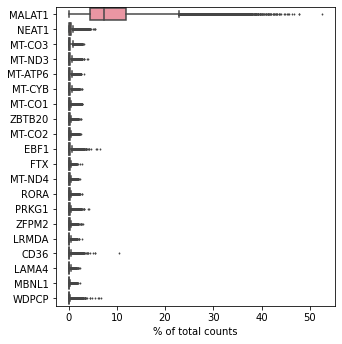

In [80]:
sc.pl.highest_expr_genes(sn_adata, n_top=20, )

In [81]:
#filtering genes present in less than 5 cells:
#and cells with less than 200 genes
sc.pp.filter_cells(sn_adata, min_genes=200)
sc.pp.filter_genes(sn_adata, min_cells=3)

/beevol/home/ivicha/miniconda3/envs/env_ml/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'feature_types' as categorical


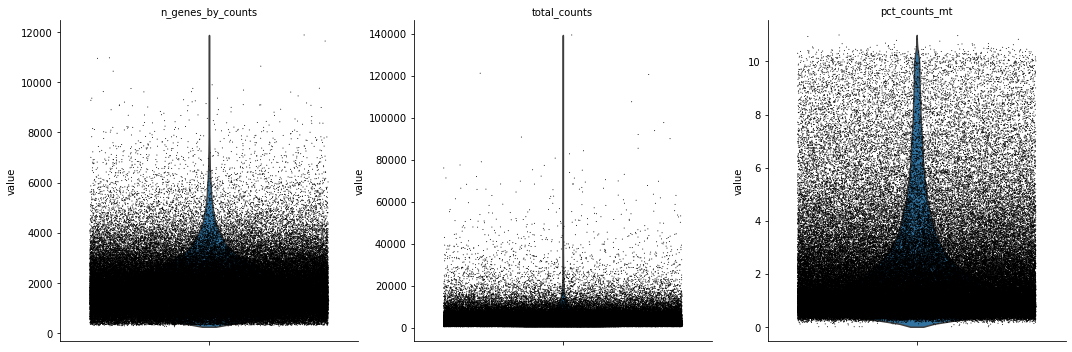

In [82]:
# remove genes with high mitochondrial content
sn_adata.var['mt'] = sn_adata.var_names.str.startswith('MT')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(sn_adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
sc.pl.violin(sn_adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

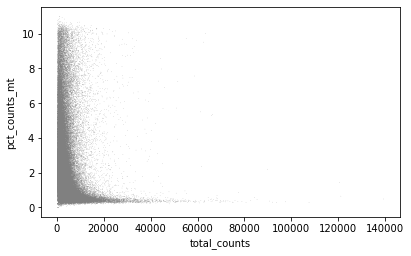

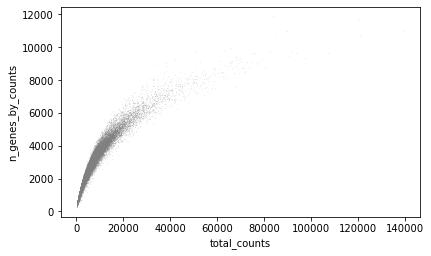

In [83]:
sc.pl.scatter(sn_adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(sn_adata, x='total_counts', y='n_genes_by_counts')

In [84]:
sn_adata = sn_adata[sn_adata.obs.n_genes_by_counts < 6000, :]
sn_adata = sn_adata[sn_adata.obs.pct_counts_mt < 5, :]

In [85]:
#making copy to keep unnormalized
sn_adata_copy = sn_adata.copy()

In [86]:
# normalize to 10K counts per cell
sc.pp.normalize_total(sn_adata, target_sum=1e4)
#logging local adata
sc.pp.log1p(sn_adata)

/beevol/home/ivicha/miniconda3/envs/env_ml/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


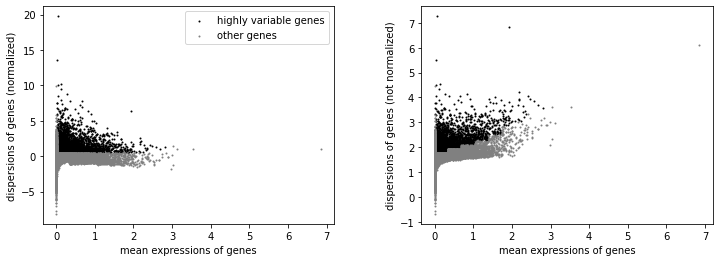

In [87]:
highly_var_genes = sc.pp.highly_variable_genes(sn_adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.highly_variable_genes(sn_adata)

Assigning cell types:

In [88]:
# Merge the two DataFrames based on the indexes
merged_df = pd.merge(sn_adata.obs, cell_meta, left_index=True, right_index=True)
merged_df

,n_genes_x,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,cell_id,biosample_id,biosample_type,library_preparation_protocol__ontology_id,library_preparation_protocol__ontology_label,...,ribosomal_protein_percent,sct__n_umis,sct__n_genes,cell_cycle__s_score,cell_cycle__g2m_score,cell_cycle__phase,cell_type__ontology_id,cell_type__ontology_label,cell_type__custom,cell_subtype__custom
Hs_OAT_12-1_AAACCCAAGCACAAAT,523,523,622.0,25.0,4.019292,Hs_OAT_12-1_AAACCCAAGCACAAAT,Hs_OAT_12-1,PrimaryBioSample_Tissue,EFO:0009922,10x 3' v3 sequencing,...,1.286174,1401,556,0.007643,0.030800,G2M,CL:0002334,preadipocyte,ASPC,hASPC1
Hs_OAT_12-1_AAACCCAAGCGTATGG,866,866,1231.0,58.0,4.711617,Hs_OAT_12-1_AAACCCAAGCGTATGG,Hs_OAT_12-1,PrimaryBioSample_Tissue,EFO:0009922,10x 3' v3 sequencing,...,0.649878,1762,866,-0.018428,0.010609,G2M,CL:0000077,mesothelial cell,mesothelium,hMes2
Hs_OAT_12-1_AAACCCAAGCTCGTGC,1023,1023,1309.0,19.0,1.451490,Hs_OAT_12-1_AAACCCAAGCTCGTGC,Hs_OAT_12-1,PrimaryBioSample_Tissue,EFO:0009922,10x 3' v3 sequencing,...,1.069519,1681,1023,-0.026009,-0.015240,G1,CL:0000077,mesothelial cell,mesothelium,hMes1
Hs_OAT_12-1_AAACCCAAGTGGATAT,1516,1516,2154.0,93.0,4.317549,Hs_OAT_12-1_AAACCCAAGTGGATAT,Hs_OAT_12-1,PrimaryBioSample_Tissue,EFO:0009922,10x 3' v3 sequencing,...,0.510678,2160,1516,-0.026939,0.031461,G2M,CL:0000669,pericyte cell,pericyte,hPeri
Hs_OAT_12-1_AAACCCAAGTTCGCAT,1666,1666,3549.0,42.0,1.183432,Hs_OAT_12-1_AAACCCAAGTTCGCAT,Hs_OAT_12-1,PrimaryBioSample_Tissue,EFO:0009922,10x 3' v3 sequencing,...,0.309946,2692,1666,-0.011481,-0.013545,G1,CL:0000136,fat cell,adipocyte,hAd2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Hs_SAT_11-1_TTTGGAGTCGACGAGA,2479,2479,5314.0,230.0,4.328190,Hs_SAT_11-1_TTTGGAGTCGACGAGA,Hs_SAT_11-1,PrimaryBioSample_Tissue,EFO:0009922,10x 3' v3 sequencing,...,0.338728,3560,2341,-0.005544,-0.007437,G1,CL:0002334,preadipocyte,ASPC,hASPC2
Hs_SAT_11-1_TTTGGAGTCTCCGATC,1813,1813,3184.0,58.0,1.821608,Hs_SAT_11-1_TTTGGAGTCTCCGATC,Hs_SAT_11-1,PrimaryBioSample_Tissue,EFO:0009922,10x 3' v3 sequencing,...,0.251256,3066,1811,0.008630,0.010638,G2M,CL:0002334,preadipocyte,ASPC,hASPC5
Hs_SAT_11-1_TTTGGTTAGTGATGGC,4520,4520,17086.0,50.0,0.292637,Hs_SAT_11-1_TTTGGTTAGTGATGGC,Hs_SAT_11-1,PrimaryBioSample_Tissue,EFO:0009922,10x 3' v3 sequencing,...,0.163877,2913,1778,-0.006596,-0.022388,G1,CL:0000136,fat cell,adipocyte,hAd4
Hs_SAT_11-1_TTTGGTTTCATGCCAA,1171,1171,1758.0,39.0,2.218430,Hs_SAT_11-1_TTTGGTTTCATGCCAA,Hs_SAT_11-1,PrimaryBioSample_Tissue,EFO:0009922,10x 3' v3 sequencing,...,0.000000,2255,1171,0.001052,-0.011141,S,CL:0000136,fat cell,adipocyte,hAd2


In [89]:
# Extract the cell type labels from the merged DataFrame
cell_type_labels = merged_df["cell_type__ontology_label"]

# Assign the cell type labels to the adata.obs DataFrame
sn_adata.obs["cell_types"] = cell_type_labels
sn_adata_copy.obs["cell_types"] = cell_type_labels

In [90]:
####QC### celltype assignments:  
# adata[idx].obs["cell_types"] = cell_meta["cell_type__ontology_label"][idx]
sn_adata['Hs_OAT_12-1_AAACCCAAGCACAAAT'].obs["cell_types"] == cell_meta["cell_type__ontology_label"]['Hs_OAT_12-1_AAACCCAAGCACAAAT']

Hs_OAT_12-1_AAACCCAAGCACAAAT    True
Name: cell_types, dtype: bool

In [91]:
sn_adata['Hs_SAT_266-1_TTTGTTGGTAATGCGG'].obs["cell_types"] == cell_meta["cell_type__ontology_label"]['Hs_SAT_266-1_TTTGTTGGTAATGCGG']

Hs_SAT_266-1_TTTGTTGGTAATGCGG    True
Name: cell_types, dtype: bool

In [92]:
#saving for later adata as anndata
adata_path = os.path.join(aug_data_path, f"{res_name}_adata.h5ad")
adata_path = Path(adata_path)
sn_adata.write_h5ad(adata_path)

#saving for later adata as anndata withour log
adata_path = os.path.join(aug_data_path, f"{res_name}_adata_notlog.h5ad")
adata_path = Path(adata_path)
sn_adata_copy.write_h5ad(adata_path)

/beevol/home/ivicha/miniconda3/envs/env_ml/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'cell_types' as categorical
/beevol/home/ivicha/miniconda3/envs/env_ml/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'cell_types' as categorical


         Falling back to preprocessing with `sc.pp.pca` and default params.


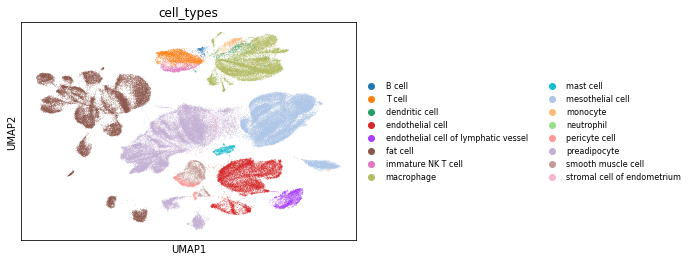

In [93]:
# calculate neighborhood graph
sc.pp.neighbors(sn_adata)

# make umap
sc.tl.umap(sn_adata)

# plot some markers of the RAW data
sc.pl.umap(sn_adata, color='cell_types', legend_fontsize=8)

In [94]:
Counter(sn_adata.obs["cell_types"])

Counter({'preadipocyte': 28725,
         'mesothelial cell': 27412,
         'pericyte cell': 1255,
         'fat cell': 24999,
         'macrophage': 14543,
         'endothelial cell': 12657,
         'endothelial cell of lymphatic vessel': 2484,
         'T cell': 3629,
         'dendritic cell': 764,
         'smooth muscle cell': 2596,
         'B cell': 272,
         'mast cell': 962,
         'monocyte': 820,
         'immature NK T cell': 1301,
         'stromal cell of endometrium': 295,
         'neutrophil': 94})

Interesection File:

In [27]:
# write out the gene ids in intersection file
genes_all = sn_adata.var["gene_ids"]
gene_out_file = os.path.join(aug_data_path, "intersection_genes.pkl")
gene_out_path = Path(gene_out_file)
pickle.dump( genes_all, open(gene_out_path, "wb" ) )

And Pseudobulk-creating loops:
1. All noise added
2. No noise added
3. No sample noise added, all other noise added.

Run all or one at a time as needed.

In [28]:
Counter(sn_adata_copy.obs["cell_types"])

Counter({'preadipocyte': 28725,
         'mesothelial cell': 27412,
         'pericyte cell': 1255,
         'fat cell': 24999,
         'macrophage': 14543,
         'endothelial cell': 12657,
         'endothelial cell of lymphatic vessel': 2484,
         'T cell': 3629,
         'dendritic cell': 764,
         'smooth muscle cell': 2596,
         'B cell': 272,
         'mast cell': 962,
         'monocyte': 820,
         'immature NK T cell': 1301,
         'stromal cell of endometrium': 295,
         'neutrophil': 94})

In [29]:
exclude = ['preadipocyte',
    'mesothelial cell',
    'pericyte cell',
    'fat cell',
    'endothelial cell',
    'endothelial cell of lymphatic vessel',
    'smooth muscle cell',
    'mast cell',
    'immature NK T cell',
    'stromal cell of endometrium',
    'neutrophil']
sn_adata_cut = sn_adata_copy[~sn_adata_copy.obs["cell_types"].isin(exclude), :]
#Tilde is “not”, so this reads like “var names that are not in exclude”
Counter(sn_adata_cut.obs["cell_types"])

Counter({'macrophage': 14543,
         'T cell': 3629,
         'dendritic cell': 764,
         'B cell': 272,
         'monocyte': 820})

In [30]:
sn_adata_cut.obs["scpred_CellType"] = sn_adata_cut.obs["cell_types"]

Trying to set attribute `.obs` of view, copying.


In [36]:
# no specific cell noise 
len_vector = sn_adata_cut.obs["cell_types"].unique().shape[0]
cell_noise = [np.random.lognormal(0, 0, sn_adata_cut.var['gene_ids'].shape[0]) for i in range(len_vector)]

# cell type order
cell_order = sn_adata_cut.obs.cell_types.unique()
#custom proportion of equal prop / cell
num_cells = len_vector
custom_prop = np.array([(1/num_cells)]*num_cells)
custom_prop  =  pd.DataFrame(custom_prop).T
custom_prop.columns = cell_order
custom_prop

,macrophage,T cell,dendritic cell,B cell,monocyte
0,0.2,0.2,0.2,0.2,0.2


In [37]:
sampling_adata = sn_adata_cut
num_cells = 2000
num_random = 200
sample_noise = None #to create noise
if make_pseudos:  
        for idx in range(0,10):
                sample_noise = None
                print(f"**idx {idx}**")
                ###########################################################################################################
                ### CALC REALISTIC CELL TYPE PROPORTIONS AND CELL TYPE SPECIFIC
                ###########################################################################################################

                # calculate the reall cell type proportion
                curr_real_prop =  sn_sc_preprocess.calc_prop(sampling_adata, cell_order=cell_order)

                # make the cell type proportion matrix
                curr_prop_df = sn_sc_preprocess.get_corr_prop_matrix(num_samp=200, 
                                                                        real_prop=curr_real_prop.values.tolist()[0],
                                                                        cell_order=cell_order, 
                                                                        min_corr=0.95)
                # get the single cell type proportions
                ct_prop_df = sn_sc_preprocess.get_single_celltype_prop_matrix(num_samp=50,
                                                                                cell_order=cell_order)

                # put them together
                curr_prop_df = curr_prop_df.append(ct_prop_df)

                ########################################################
                ### MAKE PSEUDOBULKS FOR ^^^ PROPS 
                ########################################################
                # now get the pseudobulks for both realistic and cell type specific
                prop_df, pseudobulks_df, sample_noise = sn_sc_preprocess.use_prop_make_sum(sampling_adata,  
                                                                        num_cells=num_cells, 
                                                                        props_vec=curr_prop_df, 
                                                                        cell_noise=cell_noise, #no cell noise
                                                                        sample_noise=sample_noise)


                # make the proportions instead of cell counts
                prop_df = prop_df.div(prop_df.sum(axis=1), axis=0)
                
                ###########################################################################################################
                ######   NOW THE RANDOM PROPS AND PSEUDOS  ############################
                ###########################################################################################################
                
                prop_df_new, pseudobulk_df_new, test_prop, test_expr =  sn_sc_preprocess.make_prop_and_sum(sampling_adata, 
                                                                        num_samples = num_random, 
                                                                        num_cells = num_cells, 
                                                                        use_true_prop = False, 
                                                                        cell_noise = cell_noise, #no cell noise
                                                                        sample_noise = sample_noise)
                                                                        
                # make the proportions instead of cell counts
                prop_df_new = prop_df_new.div(prop_df_new.sum(axis=1), axis=0)

                # put them together with the others
                prop_df = prop_df.append(prop_df_new)
                pseudobulks_df = pseudobulks_df.append(pseudobulk_df_new)

                ###########################################################################################################
                ### MAKE THE EQUAL PROPORTION PSEUDOS (almost equal)  ##############
                ###########################################################################################################

                # make the cell type proportion matrix  
                curr_prop_df_EQ = sn_sc_preprocess.get_prop_matrix_wnoise(custom_prop, num_bulks = 200)

                # now get the pseudobulks
                prop_df_EQ, pseudobulks_df_EQ, sample_noise = sn_sc_preprocess.use_prop_make_sum(sampling_adata,  
                                                                        num_cells=num_cells, 
                                                                        props_vec=curr_prop_df_EQ, 
                                                                        cell_noise=cell_noise, #no cell noise
                                                                        sample_noise=sample_noise)


                # make the proportions instead of cell counts
                prop_df_EQ = prop_df_EQ.div(prop_df_EQ.sum(axis=1), axis=0)

                # put them together with the rest of props and psuedos:
                prop_df = prop_df.append(prop_df_EQ)
                pseudobulks_df = pseudobulks_df.append(pseudobulks_df_EQ)

                ###########################################################################################################
                #######  SAVING   #################################################################################
                ###########################################################################################################

                pseudobulk_file = os.path.join(aug_data_path, f"{res_name}_5CTallnoise_pseudo_{idx}.pkl")
                prop_file = os.path.join(aug_data_path, f"{res_name}_5CTallnoise_prop_{idx}.pkl")

                pseudobulk_path = Path(pseudobulk_file)
                prop_path = Path(prop_file)

                pickle.dump( prop_df, open( prop_path, "wb" ) )
                pickle.dump( pseudobulks_df, open( pseudobulk_path, "wb" ) )

**idx 0**
0


/beevol/home/ivicha/pred_missing_celltypes/preprocessing/../../Greene_rotation_project/sc_bulk_ood_AI/sn_sc_preprocessing/sn_sc_preprocess.py:156: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if sample_noise != "No noise":


100


In [ ]:
# metadata
sample_order = ['single_nucleus']
stim_order = ['STIM']
train_order = ["Train"]
# now generate all the proportions
total_meta_df = pd.DataFrame(columns = ["sample_id", "stim", "isTraining"])

# no specific cell noise 
len_vector = sn_adata.obs["cell_types"].unique().shape[0]
cell_noise = [np.random.lognormal(0, 0, sn_adata.var['gene_ids'].shape[0]) for i in range(len_vector)]

# cell type order
cell_order = sn_adata.obs.cell_types.unique()
num_random = 200 #number of random pseudos

sn_adata.obs['scpred_CellType'] = sn_adata.obs["cell_types"] #to match var name in functions
sn_adata_copy.obs['scpred_CellType'] = sn_adata.obs["cell_types"]

In [40]:
sampling_adata = sn_adata_copy
num_cells = 5000
num_random = 200
sample_noise = "No noise"
if make_pseudos:  
        for idx in range(0,10):
                sample_noise = "No noise"
                print(f"**idx {idx}**")
                ###########################################################################################################
                ### CALC REALISTIC CELL TYPE PROPORTIONS AND CELL TYPE SPECIFIC
                ###########################################################################################################

                # calculate the reall cell type proportion
                curr_real_prop =  sn_sc_preprocess.calc_prop(sampling_adata, cell_order=cell_order)

                # make the cell type proportion matrix
                curr_prop_df = sn_sc_preprocess.get_corr_prop_matrix(num_samp=200, 
                                                                        real_prop=curr_real_prop.values.tolist()[0],
                                                                        cell_order=cell_order, 
                                                                        min_corr=0.95)
                # get the single cell type proportions
                ct_prop_df = sn_sc_preprocess.get_single_celltype_prop_matrix(num_samp=50,
                                                                                cell_order=cell_order)

                # put them together
                curr_prop_df = curr_prop_df.append(ct_prop_df)
                sample_noise = "No noise"
                ########################################################
                ### MAKE PSEUDOBULKS FOR ^^^ PROPS 
                ########################################################
                # now get the pseudobulks for both realistic and cell type specific
                prop_df, pseudobulks_df, sample_noise = sn_sc_preprocess.use_prop_make_sum(sampling_adata,  
                                                                        num_cells=num_cells, 
                                                                        props_vec=curr_prop_df, 
                                                                        cell_noise=cell_noise, #no cell noise
                                                                        sample_noise=sample_noise)

                sample_noise = "No noise"
                # make the proportions instead of cell counts
                prop_df = prop_df.div(prop_df.sum(axis=1), axis=0)
                
                ###########################################################################################################
                ######   NOW THE RANDOM PROPS AND PSEUDOS  ############################
                ###########################################################################################################
                
                prop_df_new, pseudobulk_df_new, test_prop, test_expr =  sn_sc_preprocess.make_prop_and_sum(sampling_adata, 
                                                                        num_samples = num_random, 
                                                                        num_cells = num_cells, 
                                                                        use_true_prop = False, 
                                                                        cell_noise = cell_noise, #no cell noise
                                                                        sample_noise = sample_noise)
                                                                        
                # make the proportions instead of cell counts
                prop_df_new = prop_df_new.div(prop_df_new.sum(axis=1), axis=0)

                # put them together with the others
                prop_df = prop_df.append(prop_df_new)
                pseudobulks_df = pseudobulks_df.append(pseudobulk_df_new)

                ###########################################################################################################
                ### MAKE THE EQUAL PROPORTION PSEUDOS (almost equal)  ##############
                ###########################################################################################################

                # make the cell type proportion matrix  
                curr_prop_df_EQ = sn_sc_preprocess.get_prop_matrix_wnoise(custom_prop, num_bulks = 200)

                # now get the pseudobulks
                prop_df_EQ, pseudobulks_df_EQ, sample_noise = sn_sc_preprocess.use_prop_make_sum(sampling_adata,  
                                                                        num_cells=num_cells, 
                                                                        props_vec=curr_prop_df_EQ, 
                                                                        cell_noise=cell_noise, #no cell noise
                                                                        sample_noise=sample_noise)


                # make the proportions instead of cell counts
                prop_df_EQ = prop_df_EQ.div(prop_df_EQ.sum(axis=1), axis=0)

                # put them together with the rest of props and psuedos:
                prop_df = prop_df.append(prop_df_EQ)
                pseudobulks_df = pseudobulks_df.append(pseudobulks_df_EQ)

                ###########################################################################################################
                #######  SAVING   #################################################################################
                ###########################################################################################################

                pseudobulk_file = os.path.join(aug_data_path, f"{res_name}_nonoise_pseudo_{idx}.pkl")
                prop_file = os.path.join(aug_data_path, f"{res_name}_nonoise_prop_{idx}.pkl")

                pseudobulk_path = Path(pseudobulk_file)
                prop_path = Path(prop_file)

                pickle.dump( prop_df, open( prop_path, "wb" ) )
                pickle.dump( pseudobulks_df, open( pseudobulk_path, "wb" ) )

**idx 0**
0
100
200
300
400
500
600
700
800
900
0
100
200
0
100
**idx 1**
0
100
200
300
400
500
600
700
800
900
0
100
200
0
100
**idx 2**
0
100
200
300
400
500
600
700
800
900
0
100
200
0
100
**idx 3**
0
100
200
300
400
500
600
700
800
900
0
100
200
0
100
**idx 4**
0
100
200
300
400
500
600
700
800
900
0
100
200
0
100
**idx 5**
0
100
200
300
400
500
600
700
800
900
0
100
200
0
100
**idx 6**
0
100
200
300
400
500
600
700
800
900
0
100
200
0
100
**idx 7**
0
100
200
300
400
500
600
700
800
900
0
100
200
0
100
**idx 8**
0
100
200
300
400
500
600
700
800
900
0
100
200
0
100
**idx 9**
0
100
200
300
400
500
600
700
800
900
0
100
200
0
100


In [37]:
sampling_adata = sn_adata_copy
num_cells = 5000
num_random = 200
sample_noise = "No sample noise"
if make_pseudos:  
        for idx in range(0,10):
                sample_noise = "No sample noise"
                print(f"**idx {idx}**")
                ###########################################################################################################
                ### CALC REALISTIC CELL TYPE PROPORTIONS AND CELL TYPE SPECIFIC
                ###########################################################################################################

                # calculate the reall cell type proportion
                curr_real_prop =  sn_sc_preprocess.calc_prop(sampling_adata, cell_order=cell_order)

                # make the cell type proportion matrix
                curr_prop_df = sn_sc_preprocess.get_corr_prop_matrix(num_samp=200, 
                                                                        real_prop=curr_real_prop.values.tolist()[0],
                                                                        cell_order=cell_order, 
                                                                        min_corr=0.95)
                # get the single cell type proportions
                ct_prop_df = sn_sc_preprocess.get_single_celltype_prop_matrix(num_samp=50,
                                                                                cell_order=cell_order)

                # put them together
                curr_prop_df = curr_prop_df.append(ct_prop_df)

                ########################################################
                ### MAKE PSEUDOBULKS FOR ^^^ PROPS 
                ########################################################
                # now get the pseudobulks for both realistic and cell type specific
                prop_df, pseudobulks_df, sample_noise = sn_sc_preprocess.use_prop_make_sum(sampling_adata,  
                                                                        num_cells=num_cells, 
                                                                        props_vec=curr_prop_df, 
                                                                        cell_noise=cell_noise, #no cell noise
                                                                        sample_noise=sample_noise)
                sample_noise = "No sample noise"

                # make the proportions instead of cell counts
                prop_df = prop_df.div(prop_df.sum(axis=1), axis=0)
                
                ###########################################################################################################
                ######   NOW THE RANDOM PROPS AND PSEUDOS  ############################
                ###########################################################################################################
                
                prop_df_new, pseudobulk_df_new, test_prop, test_expr =  sn_sc_preprocess.make_prop_and_sum(sampling_adata, 
                                                                        num_samples = num_random, 
                                                                        num_cells = num_cells, 
                                                                        use_true_prop = False, 
                                                                        cell_noise = cell_noise, #no cell noise
                                                                        sample_noise = sample_noise)
                                                                        
                # make the proportions instead of cell counts
                prop_df_new = prop_df_new.div(prop_df_new.sum(axis=1), axis=0)

                # put them together with the others
                prop_df = prop_df.append(prop_df_new)
                pseudobulks_df = pseudobulks_df.append(pseudobulk_df_new)

                ###########################################################################################################
                ### MAKE THE EQUAL PROPORTION PSEUDOS (almost equal)  ##############
                ###########################################################################################################

                # make the cell type proportion matrix  
                curr_prop_df_EQ = sn_sc_preprocess.get_prop_matrix_wnoise(custom_prop, num_bulks = 200)

                # now get the pseudobulks
                prop_df_EQ, pseudobulks_df_EQ, sample_noise = sn_sc_preprocess.use_prop_make_sum(sampling_adata,  
                                                                        num_cells=num_cells, 
                                                                        props_vec=curr_prop_df_EQ, 
                                                                        cell_noise=cell_noise, #no cell noise
                                                                        sample_noise=sample_noise)


                # make the proportions instead of cell counts
                prop_df_EQ = prop_df_EQ.div(prop_df_EQ.sum(axis=1), axis=0)

                # put them together with the rest of props and psuedos:
                prop_df = prop_df.append(prop_df_EQ)
                pseudobulks_df = pseudobulks_df.append(pseudobulks_df_EQ)

                ###########################################################################################################
                #######  SAVING   #################################################################################
                ###########################################################################################################

                pseudobulk_file = os.path.join(aug_data_path, f"{res_name}_nosampnoise_pseudo_{idx}.pkl")
                prop_file = os.path.join(aug_data_path, f"{res_name}_nosampnoise_prop_{idx}.pkl")

                pseudobulk_path = Path(pseudobulk_file)
                prop_path = Path(prop_file)

                pickle.dump( prop_df, open( prop_path, "wb" ) )
                pickle.dump( pseudobulks_df, open( pseudobulk_path, "wb" ) )

**idx 0**
0


/beevol/home/ivicha/pred_missing_celltypes/preprocessing/../../Greene_rotation_project/sc_bulk_ood_AI/sn_sc_preprocessing/sn_sc_preprocess.py:155: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if sample_noise != "No noise":


100
200
300
400
500
600
700
800
900


/beevol/home/ivicha/pred_missing_celltypes/preprocessing/../../Greene_rotation_project/sc_bulk_ood_AI/sn_sc_preprocessing/sn_sc_preprocess.py:195: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif sample_noise is "No noise":


0


/beevol/home/ivicha/pred_missing_celltypes/preprocessing/../../Greene_rotation_project/sc_bulk_ood_AI/sn_sc_preprocessing/sn_sc_preprocess.py:245: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  sum_over_cells = np.multiply(sum_over_cells, sample_noise)


100
200


/beevol/home/ivicha/pred_missing_celltypes/preprocessing/../../Greene_rotation_project/sc_bulk_ood_AI/sn_sc_preprocessing/sn_sc_preprocess.py:112: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif sample_noise is "No noise":


0
100
**idx 1**
0
100
200
300
400
500
600
700
800
900
0
100
200
0
100
**idx 2**
0
100
200
300
400
500
600
700
800
900
0
100
200
0
100
**idx 3**
0
100
200
300
400
500
600
700
800
900
0
100
200
0
100
**idx 4**
0
100
200
300
400
500
600
700
800
900
0
100
200
0
100
**idx 5**
0
100
200
300
400
500
600
700
800
900
0
100
200
0
100
**idx 6**
0
100
200
300
400
500
600
700
800
900
0
100
200
0
100
**idx 7**
0
100
200
300
400
500
600
700
800
900
0
100
200
0
100
**idx 8**
0
100
200
300
400
500
600
700
800
900
0
100
200
0
100
**idx 9**
0
100
200
300
400
500
600
700
800
900
0
100
200
0
100


In [32]:
#saving for later adata as df
adata_df = pd.DataFrame(sn_adata_copy.X.toarray(), columns = sn_adata_copy.var["gene_ids"].values)
adata_path = os.path.join(aug_data_path, f"{res_name}_adata_df.pkl")
adata_path = Path(adata_path)
pickle.dump( adata_df, open( adata_path, "wb" ) ) 

#QC pseudos made

In [33]:
def read_all_pseudobulk_files(data_path, file_name, num_bulks_training, num_files, noise_type):

  X_concat = None
  Y_concat = None
  meta_concat = None


  num = range(0,num_files)
  for idx in num:

    pseudobulks_df, prop_df, gene_df, metadata_df = read_single_pseudobulk_file(data_path, noise_type, file_name,  idx)
    print(idx)
    # subsample the number of bulks
      #indexes = metadata_df.groupby("stim").sample(int(num_bulks_training/2))
      #subsamp_idx = indexes.index
    subsamp_idx = np.random.choice(range(pseudobulks_df.shape[0]), num_bulks_training)
    pseudobulks_df = pseudobulks_df.iloc[subsamp_idx]
    prop_df = prop_df.iloc[subsamp_idx]
    metadata_df = metadata_df.loc[subsamp_idx]

    X_concat = pd.concat([X_concat, pseudobulks_df])
    Y_concat = pd.concat([Y_concat, prop_df])
    meta_concat = pd.concat([meta_concat, metadata_df])

  return (X_concat, Y_concat, gene_df, meta_concat)

In [42]:
def read_single_pseudobulk_file(data_path, noise_type, file_name, idx):

  pseudobulk_file = os.path.join(data_path, f"{file_name}_{noise_type}_pseudo_{idx}.pkl")

  gene_file = os.path.join(data_path, f"intersection_genes.pkl")

  pseudobulk_path = Path(pseudobulk_file)
  gene_path = Path(gene_file)

  pseudobulks_df = pickle.load( open( pseudobulk_path, "rb" ) )
  gene_df = pickle.load( open( gene_path, "rb" ) )

  num_samps = pseudobulks_df.shape[0] 

  sample_id = idx
  samp_type = "single"
  prop_file = os.path.join(data_path, f"{file_name}_{noise_type}_prop_{idx}.pkl")
  prop_path = Path(prop_file)
  prop_df = pickle.load( open( prop_path, "rb" ) )
  num_cell_type_specific = 50 * prop_df.shape[1]
  cell_prop_type = ["realistic"]*200+["cell_type_specific"]*num_cell_type_specific+['random']*200+['equal']*200

  metadata_df = pd.DataFrame(data = {"sample_id":[sample_id]*num_samps, 
                                    "cell_prop_type":cell_prop_type,
                                    "samp_type":[samp_type]*num_samps,})

  return (pseudobulks_df, prop_df, gene_df, metadata_df)

In [34]:
def get_tsne_for_plotting(encodings):
    tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=500) #perp = 20
    tsne_results = tsne.fit_transform(encodings)

    plot_df = pd.DataFrame(tsne_results[:,0:2])
    print(tsne_results.shape)
    print(plot_df.shape)
    plot_df.columns = ['tsne_0', 'tsne_1']
    return plot_df

def plot_tsne(plot_df, color_vec, ax, title=""):

    plot_df['Y'] = color_vec

    g = sns.scatterplot(
        x="tsne_0", y="tsne_1",
        data=plot_df,
        hue="Y",
        palette=sns.color_palette("hls", len(np.unique(color_vec))),
        legend="full",
        alpha=0.3, ax= ax
    )

    ax.set_title(title)
    return g

In [35]:
# Making cell type reference without scaling
sn_adata = sn_adata_copy.copy() ##unscaled adata
cell_types = sn_adata.obs["cell_types"].unique()
gene_ids = sn_adata.var["gene_ids"]
ref_raw = pd.DataFrame(index = gene_ids, columns = cell_types)

for cell_type in cell_types:
    
    cell_sample = sn_adata[sn_adata.obs["cell_types"].isin([cell_type])]
    x = cell_sample.X.mean(axis=0)
    sum_over_genes = pd.DataFrame(x).T

    #and save to df dict
    ref_raw[cell_type] = sum_over_genes.values
ref_raw

,preadipocyte,mesothelial cell,pericyte cell,fat cell,macrophage,endothelial cell,endothelial cell of lymphatic vessel,T cell,dendritic cell,smooth muscle cell,B cell,mast cell,monocyte,immature NK T cell,stromal cell of endometrium,neutrophil
gene_ids,,,,,,,,,,,,,,,,
A1BG,0.006754,0.021852,0.020717,0.001240,0.011277,0.001027,0.010870,0.013227,0.019634,0.022727,0.007353,0.014553,0.009756,0.009224,0.016949,0.00000
A1BG-AS1,0.012881,0.048300,0.037450,0.002840,0.038231,0.003160,0.025765,0.031414,0.061518,0.036980,0.033088,0.038462,0.040244,0.021522,0.044068,0.00000
A1CF,0.001044,0.000912,0.000797,0.009960,0.000894,0.001580,0.002818,0.001653,0.002618,0.001156,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
A2M,0.219635,0.166565,1.111551,0.251558,1.049828,2.228172,0.399756,1.163954,0.908377,1.350919,0.220588,1.650732,0.207317,0.831670,0.240678,0.12766
A2M-AS1,0.010792,0.006676,0.007171,0.026401,0.010452,0.027021,0.015700,0.144117,0.011780,0.010015,0.025735,0.237006,0.006098,0.119908,0.006780,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PLA2G1B,0.000000,0.000219,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
SERPINB13,0.000070,0.000000,0.000000,0.000000,0.000069,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
SLC17A2,0.000000,0.000036,0.000000,0.000080,0.000000,0.000000,0.000403,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000


In [36]:
#clippign before scaling to 95th pecentile
ref_raw_val = ref_raw.values
clip_upper = np.quantile(ref_raw_val, 0.95)
ref_raw_val = np.clip(ref_raw_val, 0, clip_upper)
#and scaling to be between values 0 and 1 to use for NNLS
scaler = MinMaxScaler()
scaler.fit(ref_raw_val)
ref_df = scaler.transform(ref_raw_val)
ref_df = pd.DataFrame(ref_df, index = gene_ids, columns = cell_types)
ref_raw = pd.DataFrame(ref_raw_val, index = gene_ids, columns = cell_types)
ref_df

,preadipocyte,mesothelial cell,pericyte cell,fat cell,macrophage,endothelial cell,endothelial cell of lymphatic vessel,T cell,dendritic cell,smooth muscle cell,B cell,mast cell,monocyte,immature NK T cell,stromal cell of endometrium,neutrophil
gene_ids,,,,,,,,,,,,,,,,
A1BG,0.016603,0.053719,0.050930,0.003048,0.027722,0.002525,0.026721,0.032516,0.048266,0.055871,0.018076,0.035776,0.023984,0.022675,0.041667,0.00000
A1BG-AS1,0.031665,0.118739,0.092065,0.006982,0.093985,0.007769,0.063339,0.077225,0.151232,0.090909,0.081342,0.094551,0.098933,0.052908,0.108333,0.00000
A1CF,0.002567,0.002242,0.001959,0.024486,0.002198,0.003885,0.006928,0.004064,0.006435,0.002841,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
A2M,0.539936,0.409472,1.000000,0.618414,1.000000,1.000000,0.982733,1.000000,1.000000,1.000000,0.542279,1.000000,0.509654,1.000000,0.591667,0.31383
A2M-AS1,0.026530,0.016412,0.017629,0.064903,0.025694,0.066426,0.038597,0.354288,0.028959,0.024621,0.063266,0.582640,0.014990,0.294773,0.016667,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PLA2G1B,0.000000,0.000538,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
SERPINB13,0.000171,0.000000,0.000000,0.000000,0.000169,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
SLC17A2,0.000000,0.000090,0.000000,0.000197,0.000000,0.000000,0.000990,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000


In [58]:
X_full, Y_full, gene_df, meta_df= read_all_pseudobulk_files(data_path=aug_data_path, noise_type="5CTallnoise", file_name = res_name, num_bulks_training = 2000, num_files=10)

0
1
2
3
4
5
6
7
8
9


In [106]:
union_genes = sn_adata.var.highly_variable 
union_genes

A1BG         False
A1BG-AS1     False
A1CF         False
A2M           True
A2M-AS1       True
             ...  
PLA2G1B      False
SERPINB13    False
SLC17A2      False
TBC1D3B      False
Z82186.1     False
Name: highly_variable, Length: 28518, dtype: bool

In [107]:
X_full = X_full.loc[:,union_genes]

In [108]:
X_full

gene_ids,A2M,A2M-AS1,A2ML1,AADACL2-AS1,AADACL4,AATK,ABCA10,ABCA4,ABCA6,ABCA8,...,ZSCAN1,ZSCAN31,ZSWIM4,ZSWIM5,C2CD4B,CCL4L2,CXCL8,IGHA1,AC139722.1,AQP4
0,1484,61,18,76,4,29,370,7,2075,342,...,0,46,72,153,4,28,40,1276,2,5
0,1695,24,15,169,3,15,166,5,5237,437,...,1,46,99,91,2,45,62,2,0,0
0,1354,80,10,59,1,21,205,0,2475,291,...,0,28,57,145,5,26,12,1403,1,0
0,2003,67,14,198,6,16,204,1,4948,348,...,0,54,75,171,3,89,52,292,1,2
0,2571,138,18,204,0,16,275,2,5375,443,...,0,63,127,263,2,89,108,1,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,2399,291,4,22,0,8,327,1,657,261,...,0,31,113,433,0,78,39,4,0,2
0,2080,289,7,25,5,17,289,6,612,263,...,2,23,83,490,2,48,5,10,1,0
0,1611,104,23,103,0,25,300,1,2293,355,...,2,23,86,153,5,47,59,1071,4,1
0,2481,124,7,210,0,18,229,0,5543,399,...,0,72,136,213,6,72,60,4,7,0


In [109]:

## normalize within sample
clip_upper = np.quantile(X_full, 0.9)
X_full = np.clip(X_full, 0, clip_upper)
scaler = MinMaxScaler()
scaler.fit(X_full)

# now normalize with the scaler trained on the 
# training data
X_full = np.clip(X_full, 0, clip_upper)
X_full = scaler.transform(X_full)

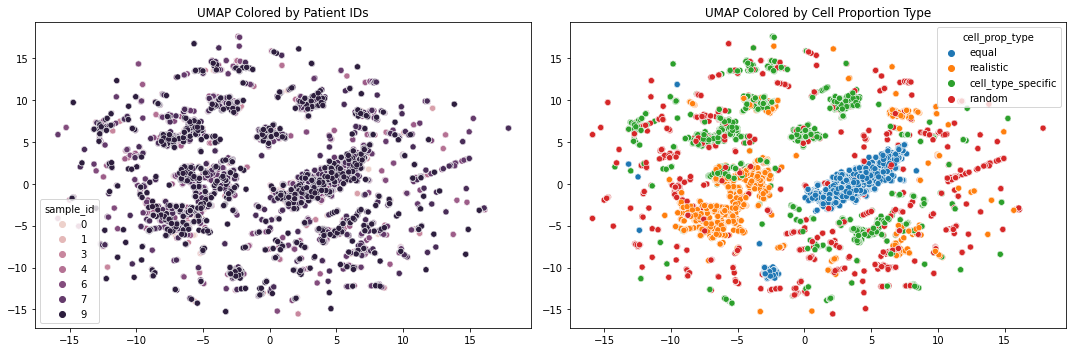

In [110]:
# Perform UMAP on X_full
umap_model = umap.UMAP(n_components=2)
umap_projection = umap_model.fit_transform(X_full)
# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Plot UMAP colored by patient IDs
sns.scatterplot(x=umap_projection[:, 0], y=umap_projection[:, 1], hue=meta_df["sample_id"], ax=axs[0])
axs[0].set_title("UMAP Colored by Patient IDs")

# Plot UMAP colored by cell proportion type
sns.scatterplot(x=umap_projection[:, 0], y=umap_projection[:, 1], hue=meta_df["cell_prop_type"], ax=axs[1])
axs[1].set_title("UMAP Colored by Cell Proportion Type")

# Adjust layout
plt.tight_layout()
plt.show()


(20000, 2)
(20000, 2)


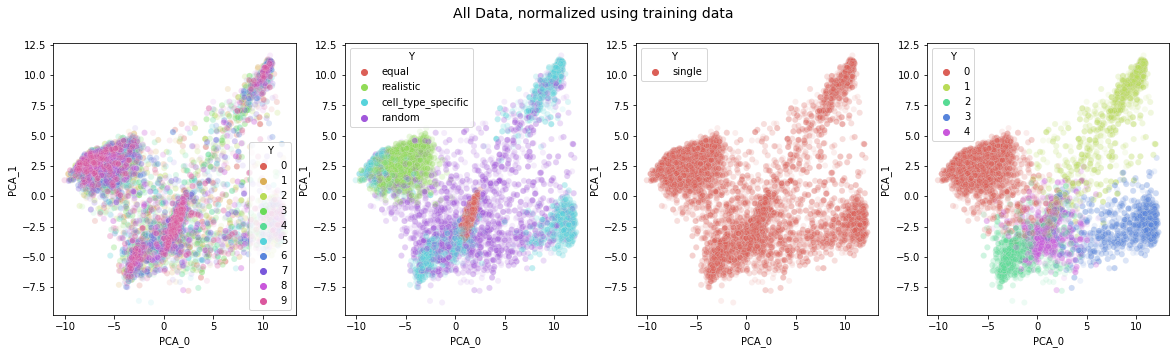

In [111]:
## plot samples
#idx_interest = np.where(meta_df.samp_type == "single")[0]

plot_df = vp.get_pca_for_plotting(X_full)

fig, axs = plt.subplots(1, 4, figsize=(20,5))

Y_temp = np.copy(Y_full)
Y_temp = np.argmax(Y_temp, axis=1) 

vp.plot_pca(plot_df, meta_df.sample_id.to_numpy(), axs[0], title=f"")
vp.plot_pca(plot_df, meta_df.cell_prop_type.to_numpy(), axs[1], title=f"")
vp.plot_pca(plot_df, meta_df.samp_type.to_numpy(), axs[2], title=f"")
vp.plot_pca(plot_df, Y_temp, axs[3], title=f"")


fig.suptitle("All Data, normalized using training data", fontsize=14)

fig.show()

/beevol/home/ivicha/miniconda3/envs/env_ml/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/beevol/home/ivicha/miniconda3/envs/env_ml/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 20000 samples in 0.116s...
[t-SNE] Computed neighbors for 20000 samples in 15.835s...
[t-SNE] Computed conditional probabilities for sample 1000 / 20000
[t-SNE] Computed conditional probabilities for sample 2000 / 20000
[t-SNE] Computed conditional probabilities for sample 3000 / 20000
[t-SNE] Computed conditional probabilities for sample 4000 / 20000
[t-SNE] Computed conditional probabilities for sample 5000 / 20000
[t-SNE] Computed conditional probabilities for sample 6000 / 20000
[t-SNE] Computed conditional probabilities for sample 7000 / 20000
[t-SNE] Computed conditional probabilities for sample 8000 / 20000
[t-SNE] Computed conditional probabilities for sample 9000 / 20000
[t-SNE] Computed conditional probabilities for sample 10000 / 20000
[t-SNE] Computed conditional probabilities for sample 11000 / 20000
[t-SNE] Computed conditional probabilities for sample 12000 / 20000
[t-SNE] Computed conditional probabilities for sa

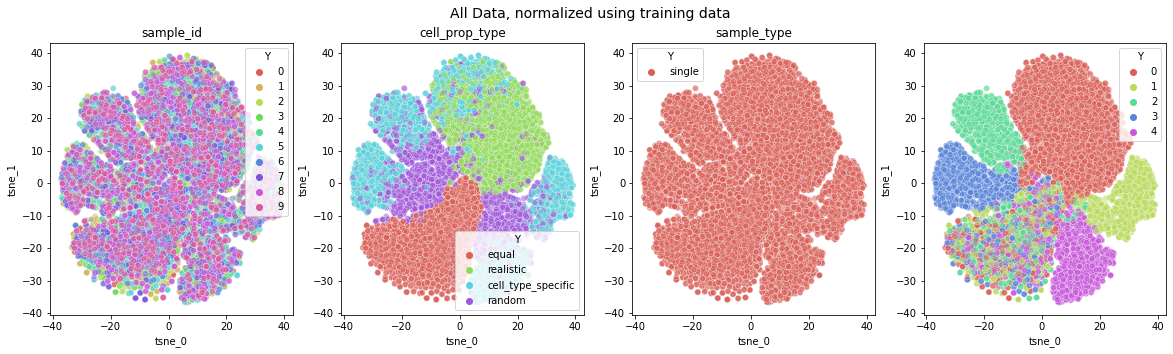

In [113]:
## plot samples
plot_df = vp.get_tsne_for_plotting(X_full)

fig, axs = plt.subplots(1, 4, figsize=(20,5))

Y_temp = np.copy(Y_full)
Y_temp = np.argmax(Y_temp, axis=1) 

vp.plot_tsne(plot_df, meta_df.sample_id.to_numpy(), axs[0], title=f"sample_id")
vp.plot_tsne(plot_df, meta_df.cell_prop_type.to_numpy(), axs[1], title=f"cell_prop_type")
vp.plot_tsne(plot_df, meta_df.samp_type.to_numpy(), axs[2], title=f"sample_type")
vp.plot_tsne(plot_df, Y_temp, axs[3], title=f"")

fig.suptitle("All Data, normalized using training data", fontsize=14)

fig.show()

In [118]:
X_full = pd.DataFrame(X_full, index = meta_df.index)
X_full
Y_full.index = meta_df.index

,0,1,2,3,4,5,6,7,8,9,...,4308,4309,4310,4311,4312,4313,4314,4315,4316,4317
801,1.0,0.084648,0.105263,0.189258,0.4,0.254386,0.444257,0.291667,1.000000,0.454128,...,0.0,0.270073,0.083333,0.185075,0.181818,0.132075,0.142857,1.000000,0.074074,0.25
22,1.0,0.031564,0.087719,0.427110,0.3,0.131579,0.099662,0.208333,1.000000,0.599388,...,0.1,0.270073,0.122807,0.092537,0.090909,0.212264,0.221429,0.002861,0.000000,0.00
817,1.0,0.111908,0.058480,0.145780,0.1,0.184211,0.165541,0.000000,1.000000,0.376147,...,0.0,0.138686,0.061404,0.173134,0.227273,0.122642,0.042857,1.000000,0.037037,0.00
11,1.0,0.093257,0.081871,0.501279,0.6,0.140351,0.163851,0.041667,1.000000,0.463303,...,0.0,0.328467,0.087719,0.211940,0.136364,0.419811,0.185714,0.417740,0.037037,0.10
26,1.0,0.195122,0.105263,0.516624,0.0,0.140351,0.283784,0.083333,1.000000,0.608563,...,0.0,0.394161,0.163743,0.349254,0.090909,0.419811,0.385714,0.001431,0.148148,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
281,1.0,0.414634,0.023392,0.051151,0.0,0.070175,0.371622,0.041667,0.903448,0.330275,...,0.0,0.160584,0.143275,0.602985,0.000000,0.367925,0.139286,0.005722,0.000000,0.10
277,1.0,0.411765,0.040936,0.058824,0.5,0.149123,0.307432,0.250000,0.800000,0.333333,...,0.2,0.102190,0.099415,0.688060,0.090909,0.226415,0.017857,0.014306,0.037037,0.00
829,1.0,0.146341,0.134503,0.258312,0.0,0.219298,0.326014,0.041667,1.000000,0.474006,...,0.2,0.102190,0.103801,0.185075,0.227273,0.221698,0.210714,1.000000,0.148148,0.05
467,1.0,0.175036,0.040936,0.531969,0.0,0.157895,0.206081,0.000000,1.000000,0.541284,...,0.0,0.459854,0.176901,0.274627,0.272727,0.339623,0.214286,0.005722,0.259259,0.00


In [120]:
idx_random = np.where(meta_df.sample_id == 0)[0]
idx_random

array([   0,    1,    2, ..., 1997, 1998, 1999])

In [121]:
X_full_1 = X_full.iloc[idx_random]
Y_full_1 = Y_full.iloc[idx_random]
meta_df_1 = meta_df.iloc[idx_random]

In [122]:
idx_random_1 = np.where(meta_df_1.cell_prop_type == "random")[0]
idx_to_add = np.where(meta_df_1.cell_prop_type == "cell_type_specific")[0]

In [123]:
idx_random_1 = np.append(idx_random_1, idx_to_add)
idx_random_1

array([  12,   14,   15, ..., 1988, 1995, 1996])

In [124]:
X_full_1 = X_full_1.iloc[idx_random_1]
Y_full_1 = Y_full_1.iloc[idx_random_1]
meta_df_1 = meta_df_1.iloc[idx_random_1]

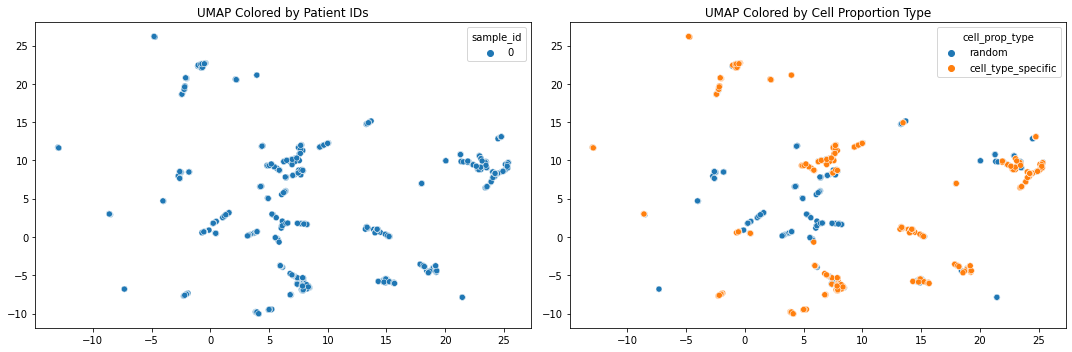

In [131]:
# Perform UMAP on X_full
umap_model = umap.UMAP(n_components=2)
umap_projection = umap_model.fit_transform(X_full_1)
# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Plot UMAP colored by patient IDs
sns.scatterplot(x=umap_projection[:, 0], y=umap_projection[:, 1], hue=meta_df_1["sample_id"], ax=axs[0])
axs[0].set_title("UMAP Colored by Patient IDs")

# Plot UMAP colored by cell proportion type
sns.scatterplot(x=umap_projection[:, 0], y=umap_projection[:, 1], hue=meta_df_1["cell_prop_type"], ax=axs[1])
axs[1].set_title("UMAP Colored by Cell Proportion Type")

# Adjust layout
plt.tight_layout()
plt.show()


(1068, 2)
(1068, 2)


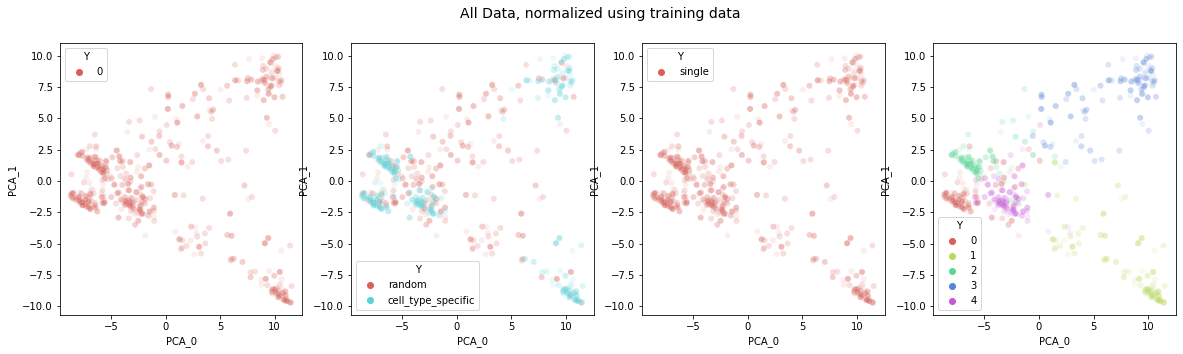

In [129]:
## plot samples
#idx_interest = np.where(meta_df_1.samp_type == "single")[0]

plot_df = vp.get_pca_for_plotting(X_full_1)

fig, axs = plt.subplots(1, 4, figsize=(20,5))

Y_temp = np.copy(Y_full_1)
Y_temp = np.argmax(Y_temp, axis=1) 

vp.plot_pca(plot_df, meta_df_1.sample_id.to_numpy(), axs[0], title=f"")
vp.plot_pca(plot_df, meta_df_1.cell_prop_type.to_numpy(), axs[1], title=f"")
vp.plot_pca(plot_df, meta_df_1.samp_type.to_numpy(), axs[2], title=f"")
vp.plot_pca(plot_df, Y_temp, axs[3], title=f"")


fig.suptitle("All Data, normalized using training data", fontsize=14)

fig.show()

/beevol/home/ivicha/miniconda3/envs/env_ml/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/beevol/home/ivicha/miniconda3/envs/env_ml/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 1068 samples in 0.005s...
[t-SNE] Computed neighbors for 1068 samples in 0.056s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1068
[t-SNE] Computed conditional probabilities for sample 1068 / 1068
[t-SNE] Mean sigma: 2.913071
[t-SNE] KL divergence after 250 iterations with early exaggeration: 58.853107
[t-SNE] KL divergence after 500 iterations: 0.340244
(1068, 2)
(1068, 2)


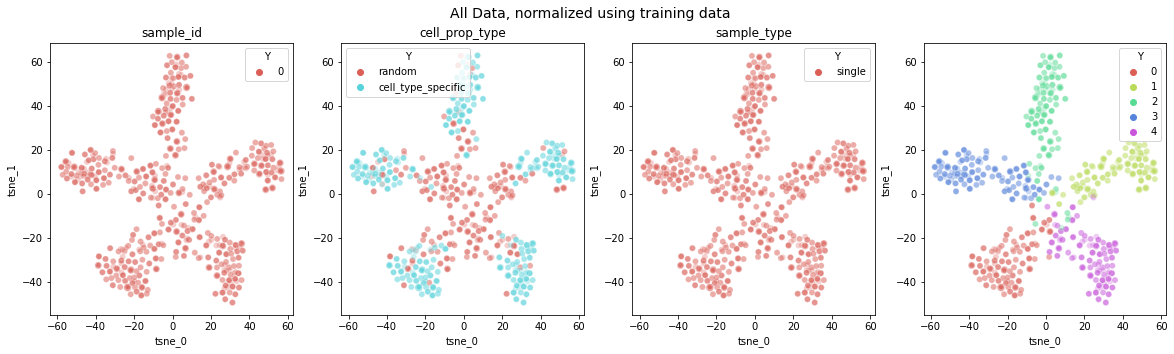

In [130]:
## plot samples
plot_df = vp.get_tsne_for_plotting(X_full_1)

fig, axs = plt.subplots(1, 4, figsize=(20,5))

Y_temp = np.copy(Y_full_1)
Y_temp = np.argmax(Y_temp, axis=1) 

vp.plot_tsne(plot_df, meta_df_1.sample_id.to_numpy(), axs[0], title=f"sample_id")
vp.plot_tsne(plot_df, meta_df_1.cell_prop_type.to_numpy(), axs[1], title=f"cell_prop_type")
vp.plot_tsne(plot_df, meta_df_1.samp_type.to_numpy(), axs[2], title=f"sample_type")
vp.plot_tsne(plot_df, Y_temp, axs[3], title=f"")

fig.suptitle("All Data, normalized using training data", fontsize=14)

fig.show()